# Pipeline

In [ ]:
!pip install optuna
#!pip install lightgbm
#!pip install scikit-learn
#!pip install pycaret

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2MB 41kB/s 


# ※ Data Loading

**단지코드가 같으면**, <br>
['지역', '임대건물구분', '단지코드', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '공가수', '단지내주차면수', '등록차량수', '총세대수']는 같고<br>
['자격유형', '임대보증금', '전용면적', '임대료', '공급유형', '전용면적별세대수']는 다름

In [ ]:
from google.colab import drive
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import optuna
from lightgbm import LGBMRegressor
import catboost as cat
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold

drive.mount('/content/gdrive')

train = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/train.csv")
test = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/test.csv")
age = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/age_gender_info.csv')
submission = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/sample_submission.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# ※ Preprocessing & Feature Engineering

나중엔 normalize랑 discretization도 할 듯

임대료, 임대보증금 '-'은 test에서도 채우고 그냥 활용하면 안되나?

## ① train set manipulation

In [ ]:
data = train

data1 = data.copy().fillna(0)
feature = data1.drop_duplicates('단지코드').sort_values('단지코드').set_index('단지코드')
feature['주거세대수'] = feature['총세대수'] - feature['공가수']

data2 = data.copy()[['단지코드', '전용면적', '전용면적별세대수']].fillna(0)
data2['총전용면적'] = data2['전용면적'] * data2['전용면적별세대수']
data2 = data2.groupby('단지코드')['총전용면적'].sum().reset_index().set_index('단지코드')

data3 = data.copy()[['단지코드', '전용면적', '전용면적별세대수']].fillna(0)
data3['전용면적'] = np.round(data3['전용면적'], -1).astype(int)
list2 = []
for i in range(10, 610, 10):
  list2.append('면적' + str(i))
  data3['면적' + str(i)] = (data3['전용면적'] == i) * data3['전용면적별세대수']
data3 = data3.groupby('단지코드')[list2].sum().reset_index().set_index('단지코드')

feature = pd.merge(feature, data2, on = '단지코드')
feature = pd.merge(feature, data3, on = '단지코드')
feature['평균전용면적'] = feature['총전용면적'] / feature['총세대수']
list1 = []
for i in train['지역'].unique():
  list1.append(i + '여부')
  feature[i + '여부'] = (feature['지역'] == i) * 1

feature['아파트여부'] = (feature['임대건물구분'] == '아파트') * 1
age = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/age_gender_info.csv')

feature = pd.merge(feature, age, how = 'left', on = '지역')

feature['공가비율'] = feature['공가수'] / feature['총세대수']

feature['등록차량수'] = (feature['등록차량수'] - feature['단지내주차면수'])

age = ["10대미만"] + [str(i) + '대' for i in range(10, 110, 10)]
for i in age:
  feature[i] = feature[i + "(여자)"] + feature[i + "(남자)"]

train_target = np.array(feature['등록차량수'] / feature['단지내주차면수'])#.astype(int)


feature_names_ = ['평균전용면적', '공가수', '40대', '50대']
train_feature = np.array(feature[feature_names_])

## ② test set manipulation

In [ ]:
data = test

data1 = data.copy().fillna(0)
feature = data1.drop_duplicates('단지코드').set_index('단지코드')
feature['주거세대수'] = feature['총세대수'] - feature['공가수']

data2 = data.copy()[['단지코드', '전용면적', '전용면적별세대수']].fillna(0)
data2['총전용면적'] = data2['전용면적'] * data2['전용면적별세대수']
data2 = data2.groupby('단지코드')['총전용면적'].sum().reset_index().set_index('단지코드')

data3 = data.copy()[['단지코드', '전용면적', '전용면적별세대수']].fillna(0)
data3['전용면적'] = np.round(data3['전용면적'], -1).astype(int)
list2 = []
for i in range(10, 610, 10):
  list2.append('면적' + str(i))
  data3['면적' + str(i)] = (data3['전용면적'] == i) * data3['전용면적별세대수']
data3 = data3.groupby('단지코드')[list2].sum().reset_index().set_index('단지코드')

feature = pd.merge(feature, data2, on = '단지코드')
feature = pd.merge(feature, data3, on = '단지코드')
feature['평균전용면적'] = feature['총전용면적'] / feature['총세대수']
list1 = []
for i in train['지역'].unique():
  list1.append(i + '여부')
  feature[i + '여부'] = (feature['지역'] == i) * 1

feature['아파트여부'] = (feature['임대건물구분'] == '아파트') * 1
age = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/age_gender_info.csv')

feature = pd.merge(feature, age, how = 'left', on = '지역')

age = ["10대미만"] + [str(i) + '대' for i in range(10, 110, 10)]
for i in age:
  feature[i] = feature[i + "(여자)"] + feature[i + "(남자)"]

feature_names_ = ['평균전용면적', '공가수', '40대', '50대']
test_feature = np.array(feature[feature_names_])

In [ ]:
test_feature.shape

(150, 4)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# feature[['평균전용면적', '공가수', '40대', '50대']] = scaler.fit_transform(feature[['평균전용면적', '공가수', '40대', '50대']])

In [ ]:
# area = train['전용면적']
# area = area.value_counts().sort_index()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



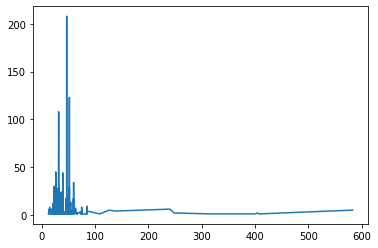

In [ ]:
#import seaborn as sns

#sns.lineplot(area.index, area.values)
#sns.histplot(area, binwidth = 10)

# train['전용면적'].describe()

# for colname in feature.columns :
#  print(colname)

# ※ Modeling

## LGBM

In [ ]:
for colname in feature.columns :
  print(colname)

In [ ]:
random_state_ = 0
n_estimators_ = 100

feature_names_ = ['평균전용면적', '공가수', '40대', '50대']
s = []
for j in range(40):
  scores = []
  learning_rate_ = 0.01

  train_target = np.array(feature['등록차량수'])
  train_feature = np.array(feature['단지내주차면수'])
  train_X, test_X, train_y, test_y = train_test_split(train_feature, train_target, test_size = 0.1, shuffle = True, random_state=random_state_)
  b = test_X.copy()
  c = test_y

  for i in range(10):
    train_target = np.array(feature['등록차량수'] / feature['단지내주차면수'])
    train_feature = np.array(feature[feature_names_])
    train_X, test_X, train_y, test_y = train_test_split(train_feature, train_target, test_size = 0.1, shuffle = True, random_state=random_state_) # train_X : feature에서 train용도로의 90% /// test_X : test용도로의 나머지 10%
    rgr = LGBMRegressor(n_estimators=n_estimators_,
                        random_state=random_state_,
                        learning_rate=learning_rate_)
    
    rgr.fit(train_X, train_y)
    score = mean_absolute_error(test_y, rgr.predict(test_X))
    learning_rate_ += 0.01

    a = rgr.predict(test_X)
    sss = mean_absolute_error(c, b * a)
    scores.append(sss)
  print(min(scores))
  s.append(min(scores))
  random_state_ += 1
print("LGBM AUC: %0.4f (+/- %0.4f)" %(np.mean(s), np.std(s) * 2))

117.61441327353589
115.88207499400868
134.6971888856049
85.43352625711017
141.1792888570643
135.08513595371787
112.92357260796183
134.1268999745059
105.85091852208119
129.91295242780956
107.27406010492884
89.98886540342407
138.26086270939155
93.39397485146785
115.83498259865523
134.7643617927108
119.42764512893427
107.47079951302199
98.36880566495282
90.45669535041408
132.7289062925234
100.9515872412667
86.475914179886
93.16921876935784
106.49971345007131
124.61877768593618
104.19454127760572
100.29164333430388
132.02698998136944
111.76625373759241
109.17008182376573
127.98338516349145
117.57984545746002
121.73169829801398
133.01436006203977
88.41911105421637
105.98328868301802
107.53320483668696
120.19612723763545
120.33587374562923
LGBM AUC: 113.8154 (+/- 31.7752)


# ※ Evaluation

In [ ]:
X_tmp, y_tmp = train_feature, train_target

X = pd.DataFrame(X_tmp)
y = pd.DataFrame(y_tmp)

In [ ]:
X.shape

(423, 4)

In [ ]:
from sklearn.metrics import mean_absolute_error as MAE

def objective(trial):
  MAE_cv = []
  # X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

  params_lgb = {
        "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "n_estimators": trial.suggest_int("n_estimators", 300, 3000),
        "objective": "regression",
        "metric": "MAE",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 150),
        "max_bin": trial.suggest_int("max_bin", 200, 600)
  }
  

  kf = KFold(n_splits = 5)
  kf.get_n_splits(X)

  for train_index, valid_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    model = LGBMRegressor(**params_lgb)
    model.fit(
      X_train,
      y_train,
      eval_set=[(X_train, y_train), (X_valid, y_valid)], # early stopping에 쓰일
      early_stopping_rounds=100,
      verbose= False,
  )

    y_pred = model.predict(X_valid)
    MAE_cv.append( MAE(y_valid, y_pred) )
    #MAE = cross_val_score(model, X_train, y_valid, scoring="neg_mean_absolute_error", n_jobs = -1, cv = 5).mean()
    
  MAE_cv = np.mean(MAE_cv)
  return MAE_cv



sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=100)
print("Best score :", study.best_value)
print("Best params combination :", study.best_trial.params)

[I 2021-06-27 13:55:10,141] A new study created in memory with name: lgbm_parameter_opt
[I 2021-06-27 13:55:10,238] Trial 0 finished with value: 0.25066746835190257 and parameters: {'criterion': 'entropy', 'learning_rate': 0.03927975767245621, 'n_estimators': 1916, 'reg_alpha': 4.688999026868671e-06, 'reg_lambda': 0.014039515270313035, 'max_depth': 2, 'num_leaves': 222, 'colsample_bytree': 0.7207805082202461, 'subsample': 0.7956508044572318, 'subsample_freq': 1, 'min_child_samples': 146, 'max_bin': 533}. Best is trial 0 with value: 0.25066746835190257.
[I 2021-06-27 13:55:10,632] Trial 1 finished with value: 0.2193682005439818 and parameters: {'criterion': 'gini', 'learning_rate': 0.017336180394137354, 'n_estimators': 1121, 'reg_alpha': 1.5747445384650815e-05, 'reg_lambda': 0.03887505735834024, 'max_depth': 6, 'num_leaves': 158, 'colsample_bytree': 0.3976457024564293, 'subsample': 0.5045012539746527, 'subsample_freq': 4, 'min_child_samples': 71, 'max_bin': 514}. Best is trial 1 with va

Best score : 0.20585687259627444
Best params combination : {'criterion': 'gini', 'learning_rate': 0.04732310864033735, 'n_estimators': 1794, 'reg_alpha': 1.8838021792365857e-05, 'reg_lambda': 0.033529352741156974, 'max_depth': 7, 'num_leaves': 214, 'colsample_bytree': 0.7689248031265047, 'subsample': 0.4666918559577677, 'subsample_freq': 7, 'min_child_samples': 24, 'max_bin': 534}


In [ ]:
submission

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0
...,...,...
145,C2456,0
146,C1266,0
147,C2152,0
148,C1267,0


In [ ]:
#random_state_ = 0
#n_estimators_ = 1000
#learning_rate_ = 0.003

p1 = {'criterion': 'gini', 'learning_rate': 0.023564350516418413, 'n_estimators': 1927, 'reg_alpha': 1.4495020893758453e-05, 'reg_lambda': 0.0431599890332031, 'max_depth': 4, 'num_leaves': 103, 'colsample_bytree': 0.8667476575085857, 'subsample': 0.3558779429904803, 'subsample_freq': 3, 'min_child_samples': 19, 'max_bin': 465}
p2 = {'criterion': 'gini', 'learning_rate': 0.04732310864033735, 'n_estimators': 1794, 'reg_alpha': 1.8838021792365857e-05, 'reg_lambda': 0.033529352741156974, 'max_depth': 7, 'num_leaves': 214, 'colsample_bytree': 0.7689248031265047, 'subsample': 0.4666918559577677, 'subsample_freq': 7, 'min_child_samples': 24, 'max_bin': 534}

# p = {'random_state' : 0, 'n_estimators' : 1000, 'learning_rate' : 0.003}


######## LightGBM 1 ########
rgr1 = LGBMRegressor(**p1)

rgr1.fit(X, y)
tmp = feature['단지내주차면수']
prediction1 = rgr1.predict(test_feature)

submission['num'] = np.round(tmp * prediction1 + tmp)
submission.to_csv('/content/gdrive/My Drive/Colab Notebooks/submissionJunParams1.csv', index = False)

######## LightGBM 2 ########
rgr2 = LGBMRegressor(**p2)

rgr2.fit(X, y)
tmp = feature['단지내주차면수']
prediction2 = rgr2.predict(test_feature)

submission['num'] = np.round(tmp * prediction2 + tmp)
submission.to_csv('/content/gdrive/My Drive/Colab Notebooks/submissionJunParams2.csv', index = False)